In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.regression.gmm import IV2SLS

In [2]:
def get_weekday_name(date):
    '''
    date : 'YYYY-MM-DD'
    return : Monday
    '''
    return date.strftime('%A')

# Function to get all days in a time period
def get_all_dates(start_date, end_date):
    delta = end_date - start_date
    return [start_date + timedelta(days=i) for i in range(delta.days + 1)]


# EDA

In [3]:
df = pd.read_csv('./Project3Data.csv')
# df = df.dropna()
df.head()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied
0,2023-01-01,1,16.0,21,2,1.0,0
1,2023-01-01,2,16.0,18,5,2.5,0
2,2023-01-01,3,16.0,10,9,4.5,0
3,2023-01-01,4,16.0,1,15,7.5,0
4,2023-01-02,1,16.0,20,2,1.0,0


- check week day name

In [5]:
# check if we have every week day evenly -> no (sunday data is very few)
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['dow'] = df.Date.apply(lambda x: get_weekday_name(x))
df['dow'].value_counts() 

dow
Sunday       72
Monday       68
Tuesday      68
Wednesday    68
Thursday     68
Friday       68
Saturday     68
Name: count, dtype: int64

- check dataset

In [5]:
# discount applied date
df[['Region','Discount Applied','Date']].groupby(['Region','Discount Applied']).agg({'Date':'min'})

Date
Region Discount Applied           
1      0                2023-01-01
2      0                2023-01-01
3      0                2023-01-01
       1                2023-03-01
4      0                2023-01-01
       1                2023-03-01

In [6]:
# unique values
df[['Region','Unit Price','Distance','Delivery Fees','Discount Applied']].drop_duplicates().sort_values(by=['Region','Distance'])

,Region,Unit Price,Distance,Delivery Fees,Discount Applied
0,1,16.0,2,1.000,0
1,2,16.0,5,2.500,0
2,3,16.0,9,4.500,0
238,3,15.2,9,4.500,1
3,4,16.0,15,7.500,0
239,4,16.0,15,7.125,1


# Plot Average

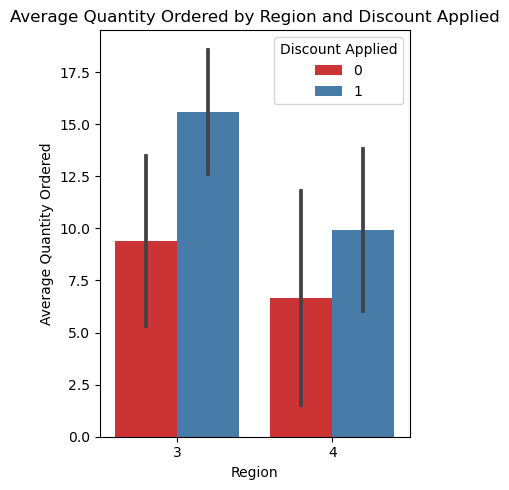

In [7]:
plt.figure(figsize=(4, 5))
sns.barplot(
    data=df[df.Region.isin([3,4])],
    x='Region',
    y='Quantity Ordered',
    hue='Discount Applied',
    errorbar='sd',  # std bar
    palette='Set1'
)

# title, label
plt.xlabel('Region')
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered by Region and Discount Applied')
plt.legend(title='Discount Applied')

plt.tight_layout()
plt.show()

# DID plot

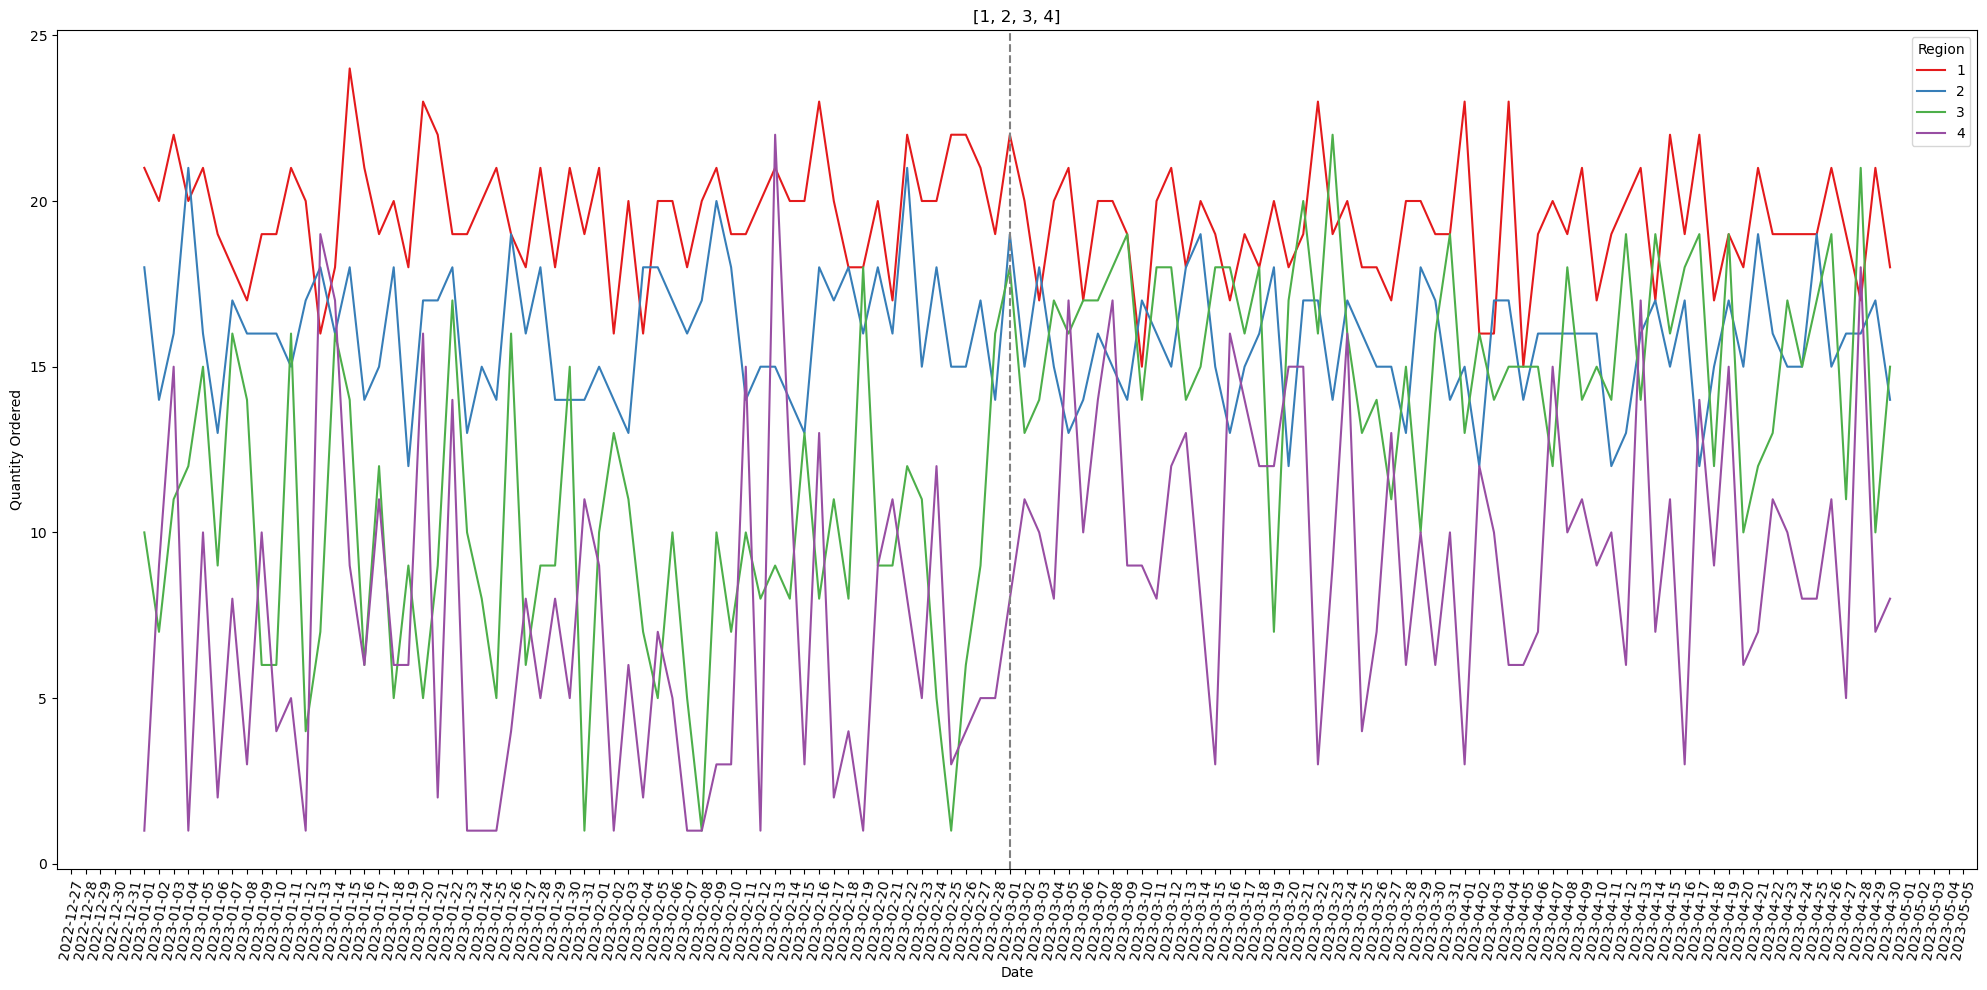

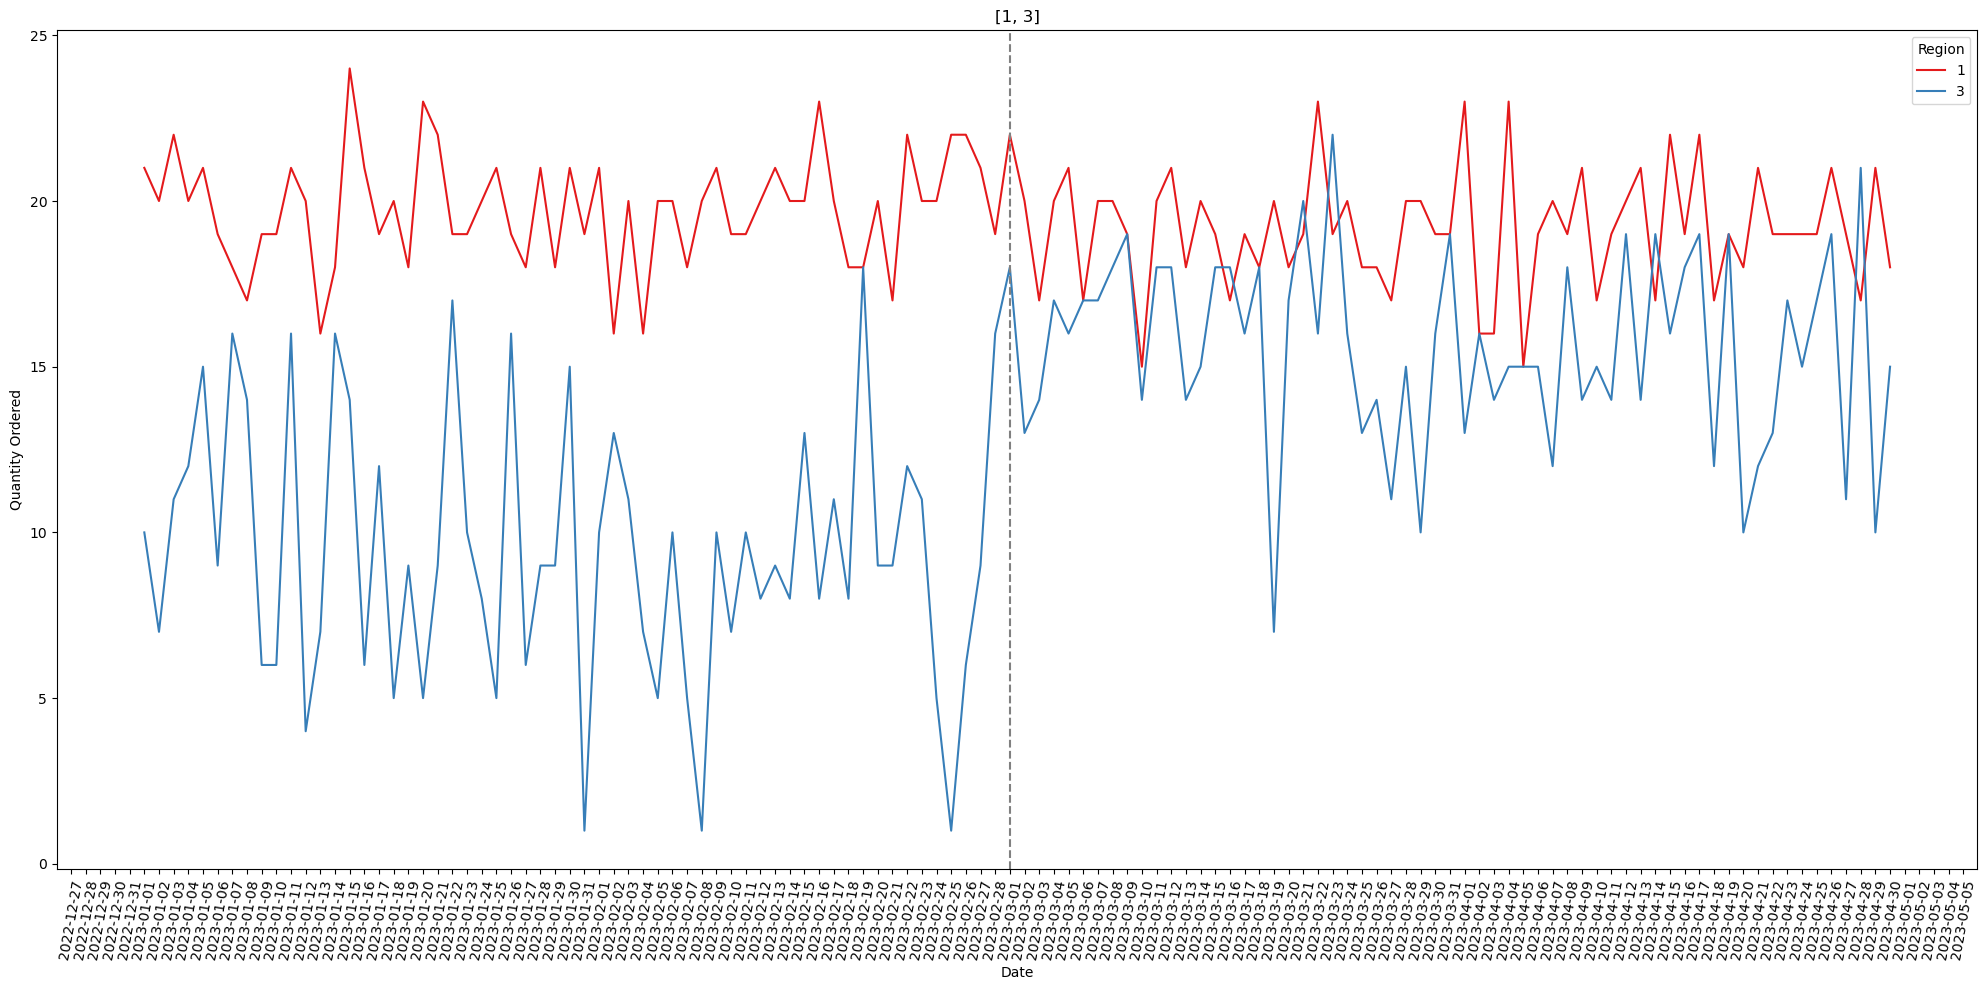

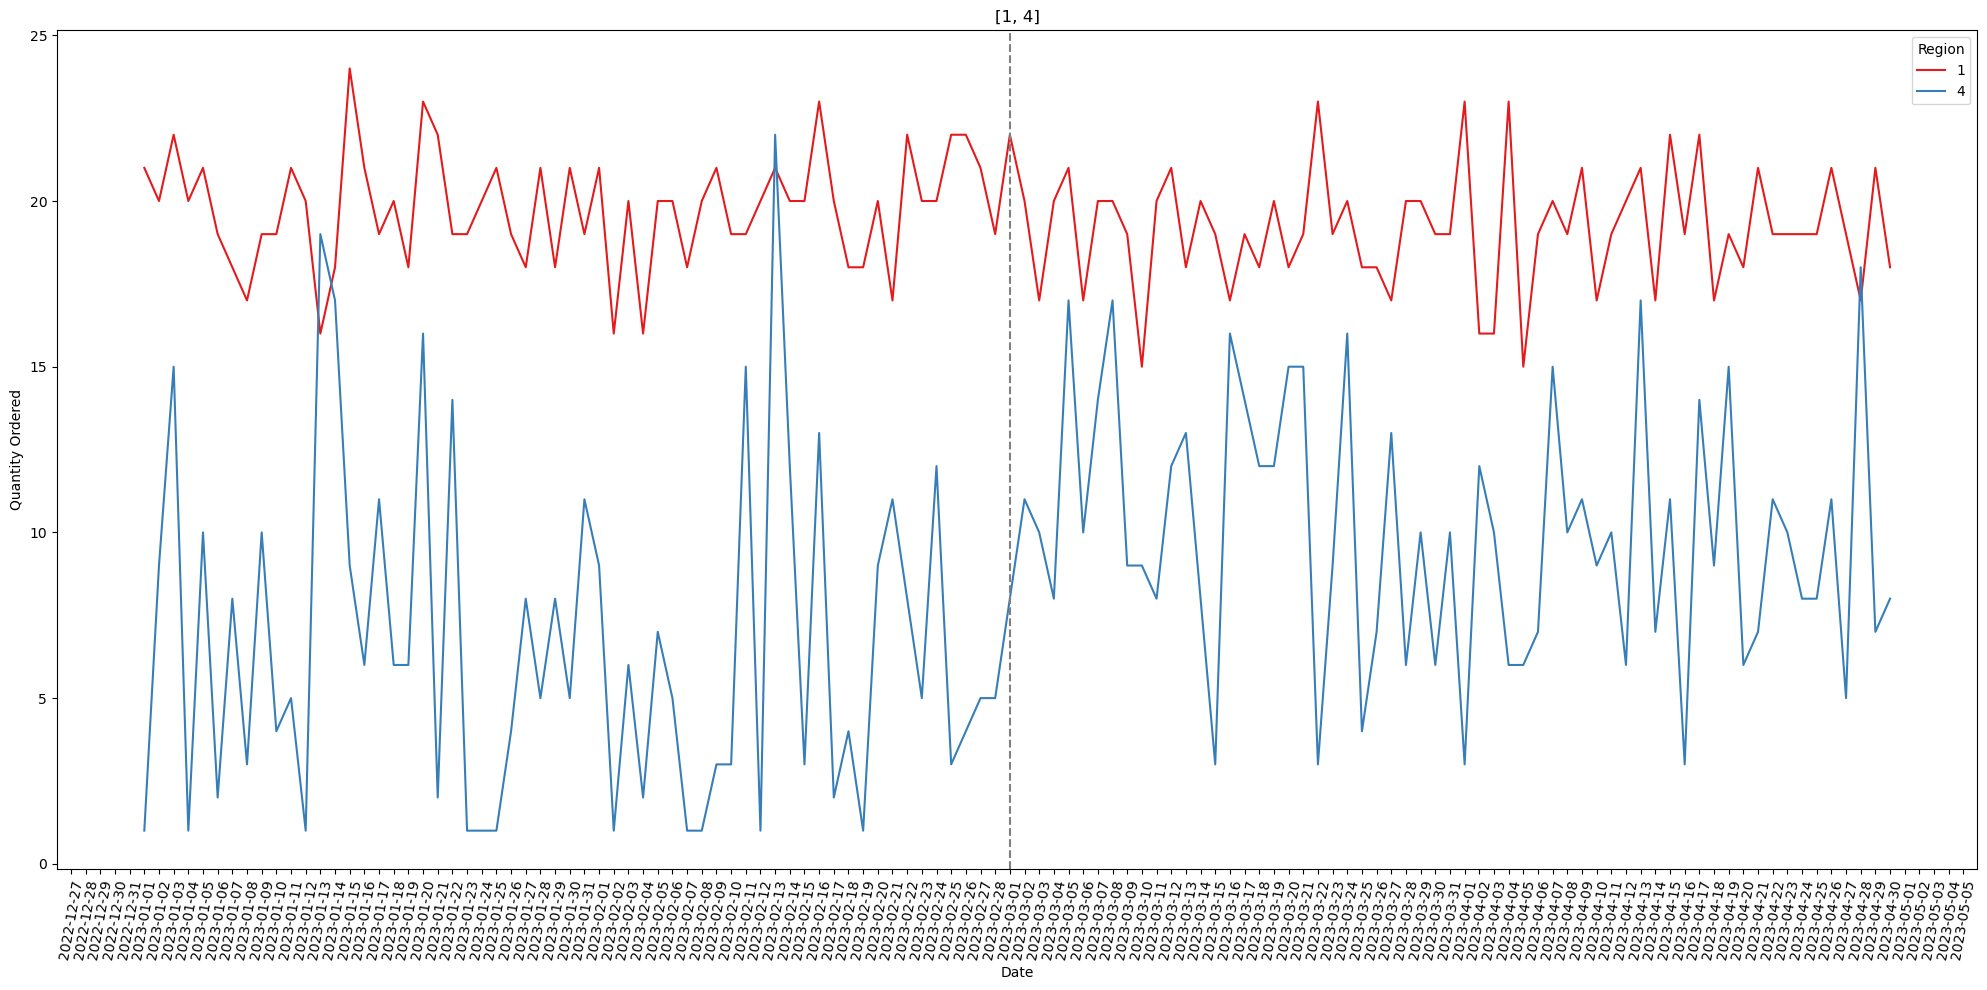

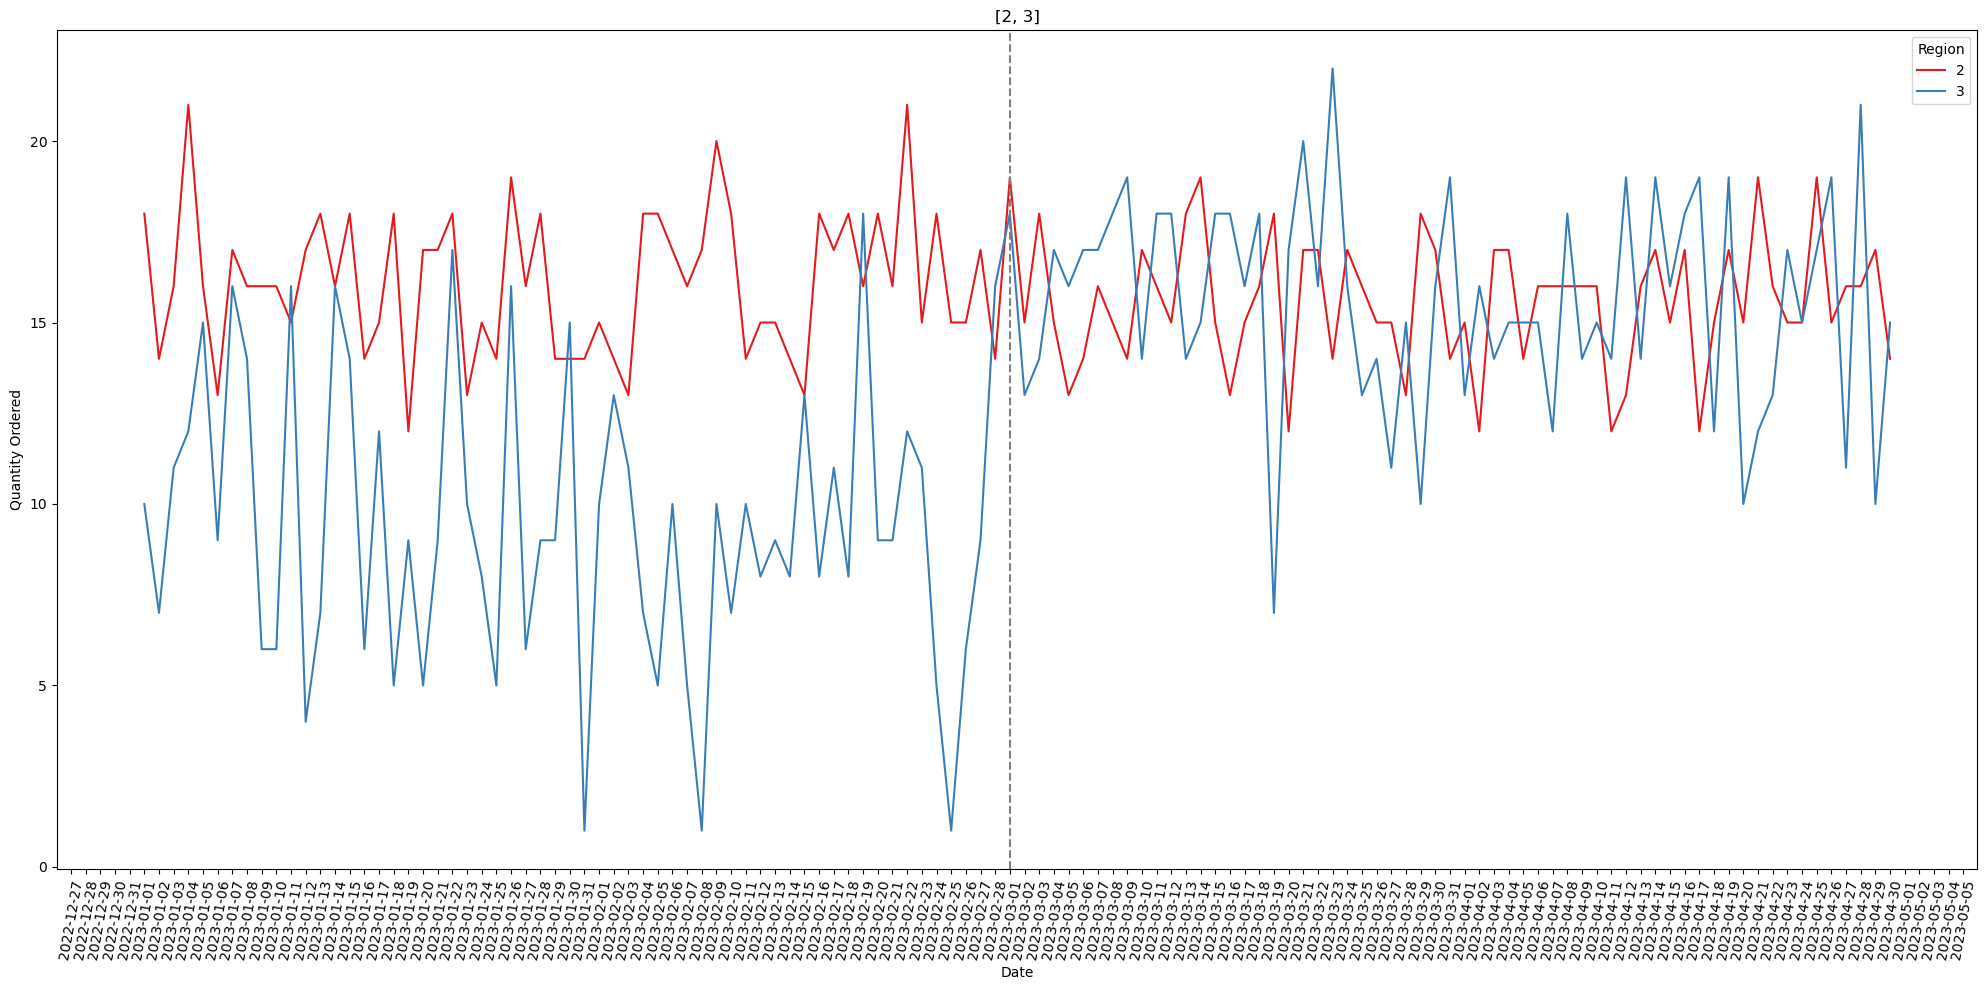

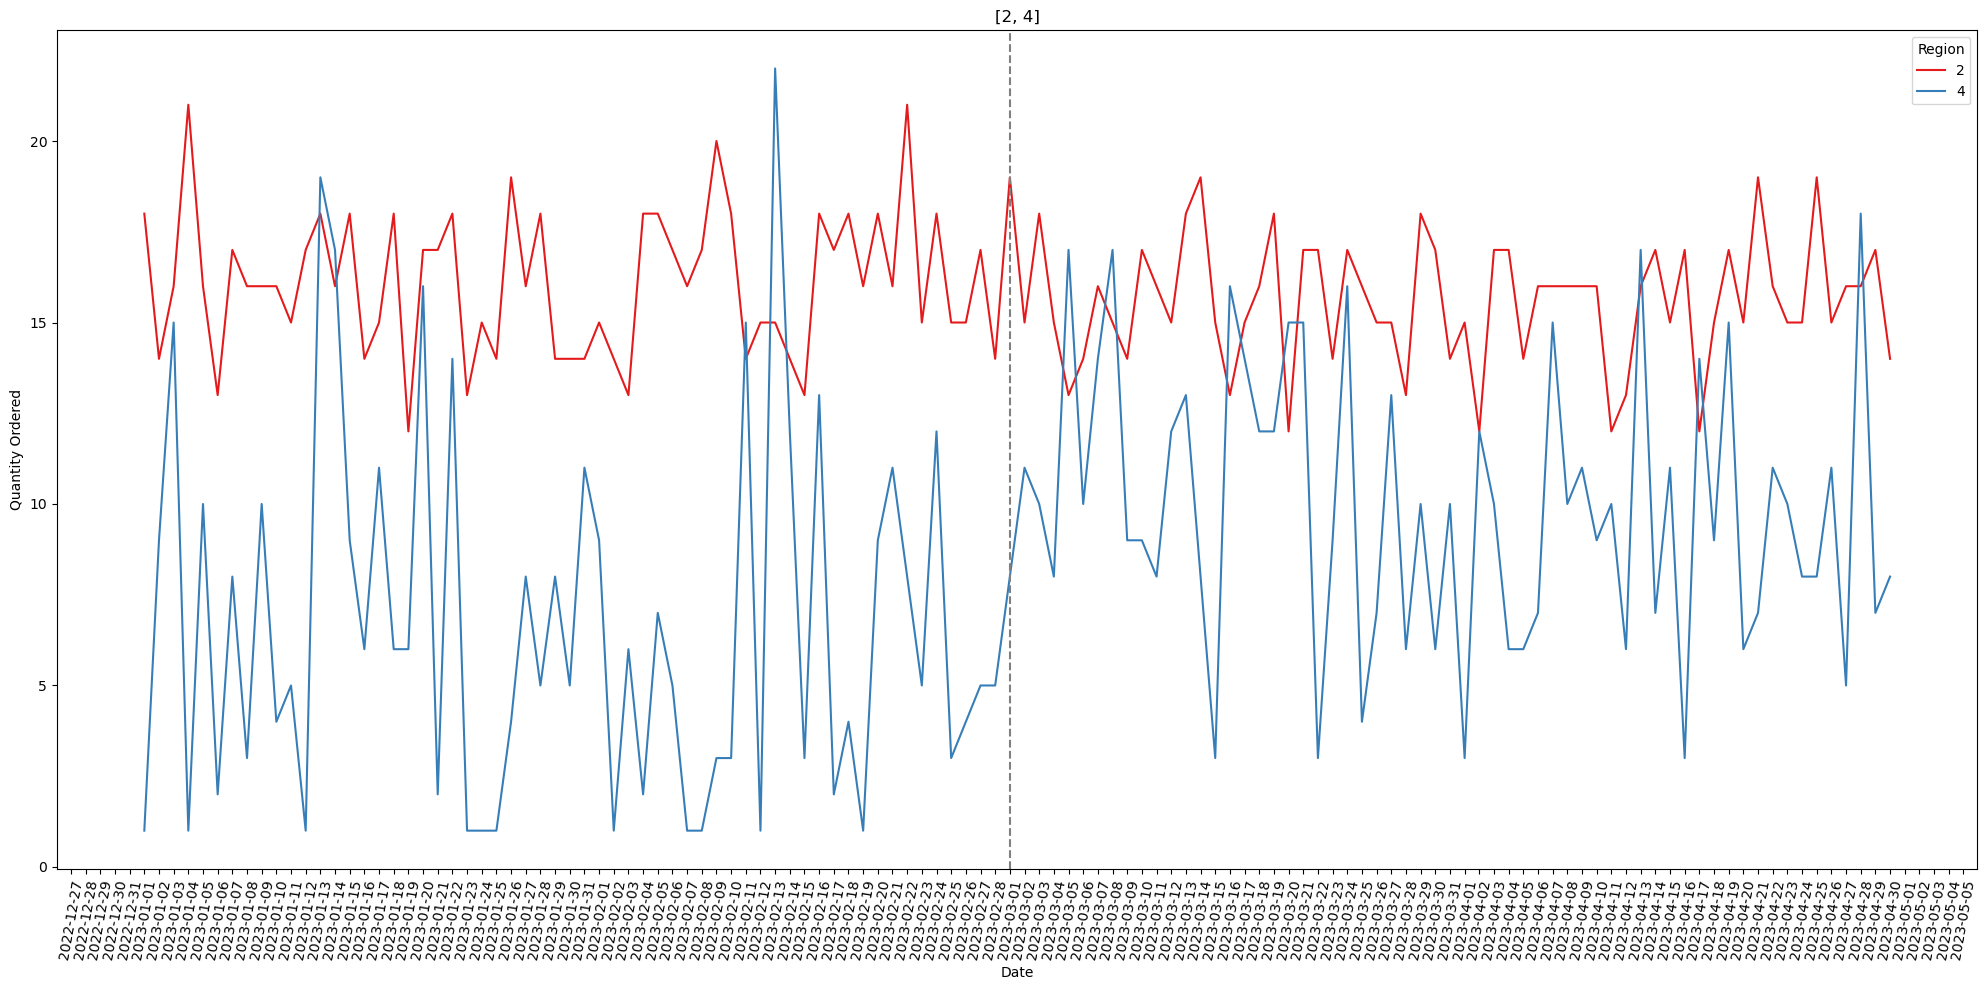

In [8]:
# plot
region_combination = [[1,2,3,4],[1,3],[1,4],[2,3],[2,4]]

for i, region in enumerate(region_combination):
    plt.figure(figsize=(20, 10))
    subset = df[df['Region'].isin(region)]
    sns.lineplot(data=subset, x='Date',y='Quantity Ordered', hue='Region', palette='Set1')

    # discount applied date
    phase_2_start = datetime(2023,3,1)
    plt.axvline(x=phase_2_start, color='grey', linestyle='--', label='Phase 2 Start')

    # x axis date format
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # everyday
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # dateformat

    plt.title(f'{region}')    
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.show()

# regression
y = a + (b1 x region) + (b2 x discount) + (b3 x region x discount) + e

In [19]:
target = df[df['Region'].isin([1,3])].drop(columns='dow')
target['Region'] = target['Region'].apply(lambda x: 0 if x==1 else 1)
target['region_discount'] = target['Region']*target['Discount Applied']
target.head()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied,region_discount
0,2023-01-01,0,16.0,21,2,1.0,0,0
2,2023-01-01,1,16.0,10,9,4.5,0,0
4,2023-01-02,0,16.0,20,2,1.0,0,0
6,2023-01-02,1,16.0,7,9,4.5,0,0
8,2023-01-03,0,16.0,22,2,1.0,0,0


In [18]:
# OLS
y=target['Quantity Ordered']
X=target[['Region','Discount Applied','region_discount']]
# X['Date'] = X['Date'].apply(lambda x: int(datetime.strftime(x,'%Y%m%d')))
X = sm.add_constant(X)
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quantity Ordered   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     252.7
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           1.74e-59
Time:                        21:48:46   Log-Likelihood:                -587.60
No. Observations:                 240   AIC:                             1181.
Df Residuals:                     237   BIC:                             1192.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.4583      0.257     75.666      0.000      18.952      19.965
Region             -10.0516      0.448    -22.440      0.000     -10.934      -9.169
Discount Applied     3.0917      0.257     12.021      0.000       2.585       3.598
region_discount      3.0917      0.257     12.021      0.000       2.585       3.598
==============================================================================
Omnibus:                        6.051   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.184
Skew:                          -0.046   Prob(JB):                       0.0101
Kurtosis:                       3.954   Cond. No.                     2.58e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.59e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


--- Check Linear Regression Assumptions ---


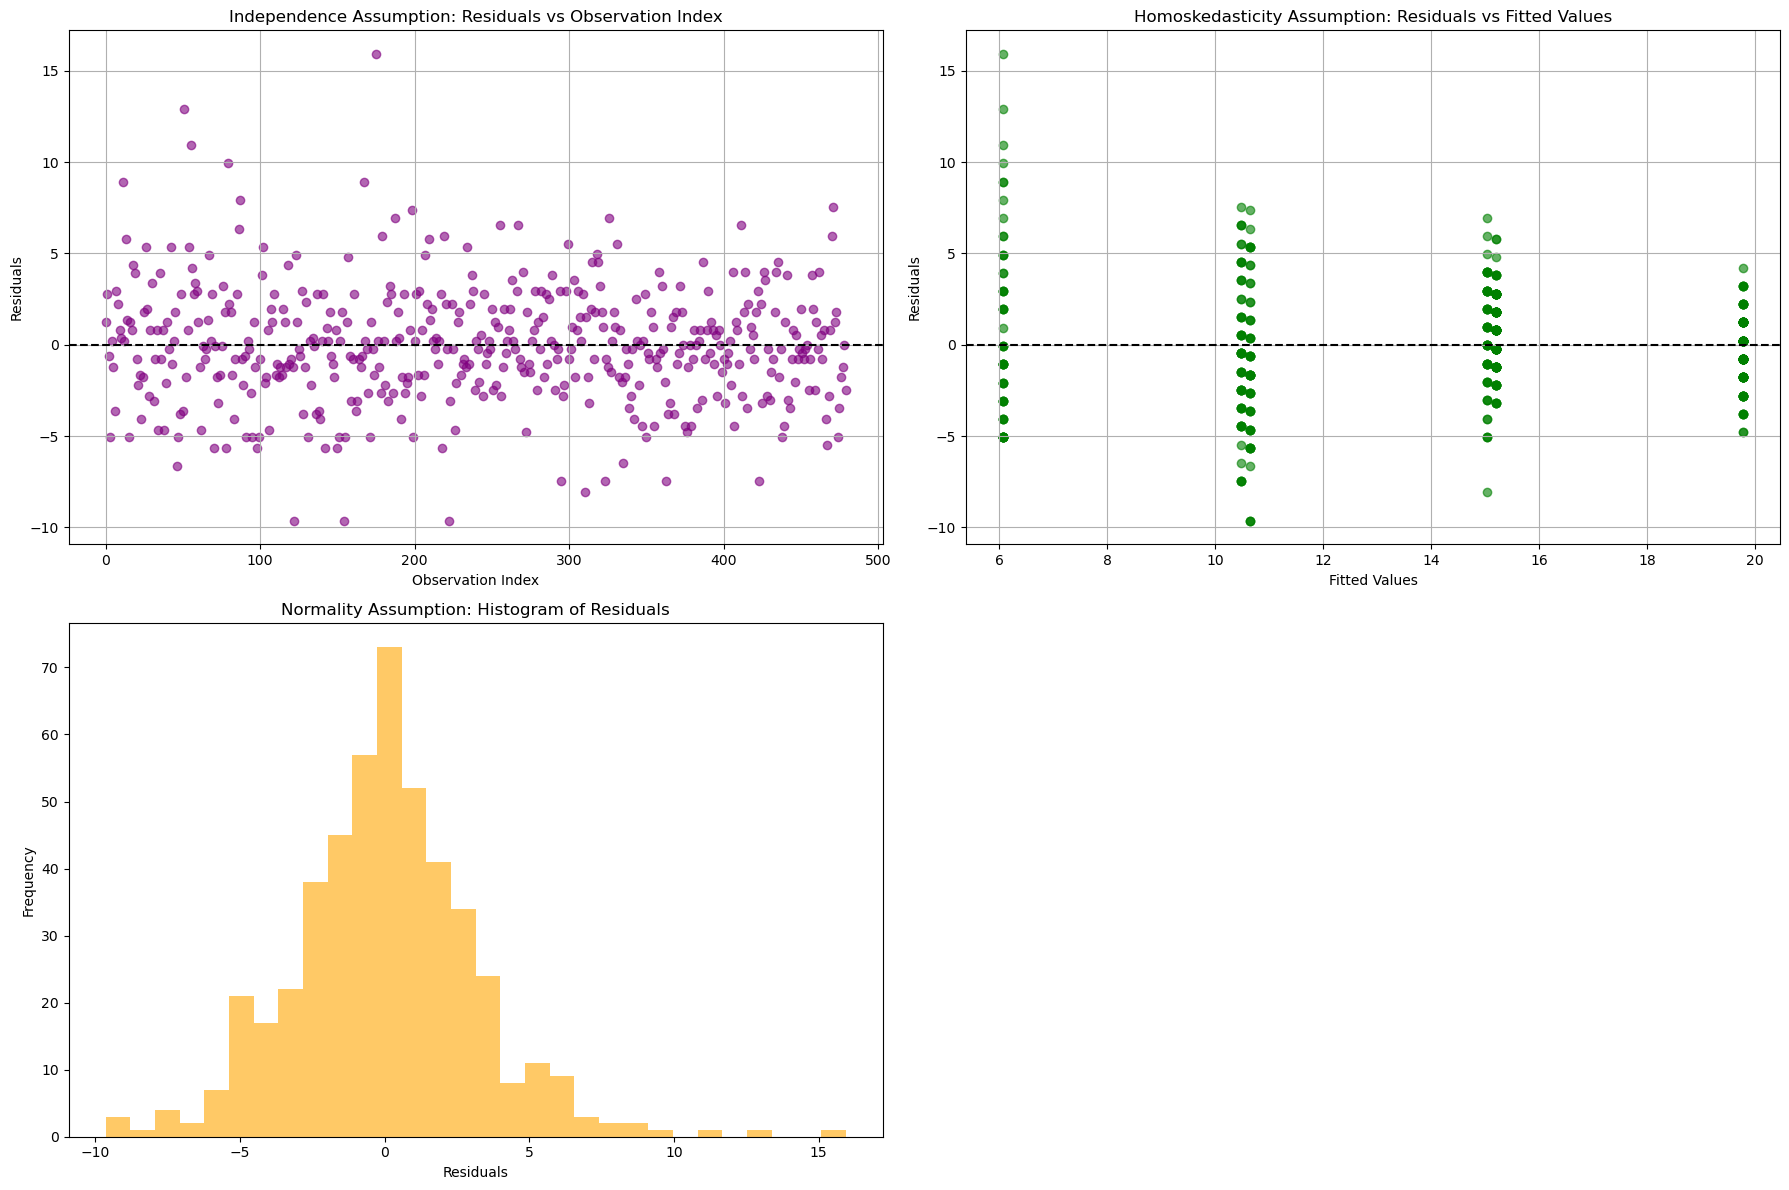


--- Multicollinearity Check (Variance Inflation Factor) ---
            Feature       VIF
1            Region  1.374808
2  Discount Applied  1.374808


In [12]:
# Fit a simple linear regression model
residuals = model.resid
fitted_values = model.fittedvalues  

plt.figure(figsize=(18, 12))
print("\n--- Check Linear Regression Assumptions ---")

# 1. Independence (Scatter plot of residuals vs observation index)
plt.subplot(2, 2, 1)
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Independence Assumption: Residuals vs Observation Index')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.grid(True)

# 2. Homoskedasticity (Residuals vs Fitted Values)
plt.subplot(2, 2, 2)
plt.scatter(fitted_values, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Homoskedasticity Assumption: Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)

# 3. Normality of Residuals (Histogram)
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, color='orange', alpha=0.6)
plt.title('Normality Assumption: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Multicollinearity Check
print("\n--- Multicollinearity Check (Variance Inflation Factor) ---")

# Calculating VIF for each independent variable (excluding the constant)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Exclude the constant (intercept) from the VIF results
vif_data = vif_data[vif_data["Feature"] != "const"]
print(vif_data)

# TSLS to get the Demand Function

TSLS regression not possible for Region 1 due to: Singular matrix
TSLS regression not possible for Region 2 due to: Singular matrix
TSLS Regression Results for Region 3:
                          IV2SLS Regression Results                           
Dep. Variable:       Quantity Ordered   R-squared:                       0.434
Model:                         IV2SLS   Adj. R-squared:                  0.429
Method:                     Two Stage   F-statistic:                     90.39
                        Least Squares   Prob (F-statistic):           2.95e-16
Date:                Fri, 08 Nov 2024                                         
Time:                        16:30:39                                         
No. Observations:                 120                                         
Df Residuals:                     118                                         
Df Model:                           1                                         
                 coef    std err        

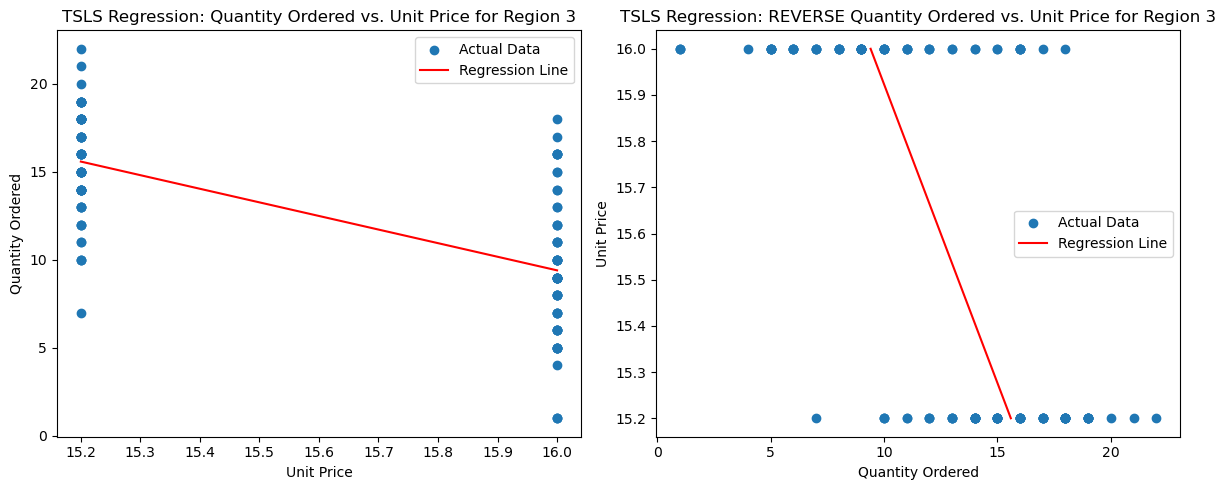

TSLS Regression Results for Region 4:
TSLS regression not possible for Region 4 due to: must have at least one row in constraint matrix


In [11]:
for region_number in df['Region'].unique():
    region_data = df[df['Region'] == region_number]
    
    # Define the dependent and independent variables
    y = region_data['Quantity Ordered']
    X = region_data[['Unit Price']] #, 'Discount Applied'
    Z = region_data[['Distance', 'Discount Applied']]  # Instruments
    
    # Check if there are enough data points to perform TSLS
    if len(region_data) < 3:
        print(f"Not enough data points to perform TSLS for Region {region_number}")
        continue
    
    # Add a constant to the independent variable (intercept)
    X = sm.add_constant(X)
    Z = sm.add_constant(Z)
    
    try:
        # Perform TSLS regression
        model_tsls = IV2SLS(y, X, instrument=Z).fit()
        
        # Print the summary of the regression
        print(f"TSLS Regression Results for Region {region_number}:")
        print(model_tsls.summary())
        print("\n")
        
        # Plot the regression line for regions 3 and 4
        if region_number in [3, 4]:
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figsize for better visualization
            axs = axs.flatten()
            
            # First plot: Quantity Ordered vs. Unit Price
            axs[0].scatter(region_data['Unit Price'], y, label='Actual Data')
            axs[0].plot(region_data['Unit Price'], model_tsls.predict(X), color='red', label='Regression Line')
            axs[0].set_xlabel('Unit Price')
            axs[0].set_ylabel('Quantity Ordered')
            axs[0].set_title(f'TSLS Regression: Quantity Ordered vs. Unit Price for Region {region_number}')
            axs[0].legend()
            
            # Second plot: REVERSE Quantity Ordered vs. Unit Price
            axs[1].scatter(y, region_data['Unit Price'], label='Actual Data')
            axs[1].plot(model_tsls.params[0] + model_tsls.params[1] * region_data['Unit Price'], region_data['Unit Price'], color='red', label='Regression Line')
            axs[1].set_ylabel('Unit Price')
            axs[1].set_xlabel('Quantity Ordered')
            axs[1].set_title(f'TSLS Regression: REVERSE Quantity Ordered vs. Unit Price for Region {region_number}')
            axs[1].legend()
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"TSLS regression not possible for Region {region_number} due to: {e}")

# Frequency of Quantity Ordered for each region

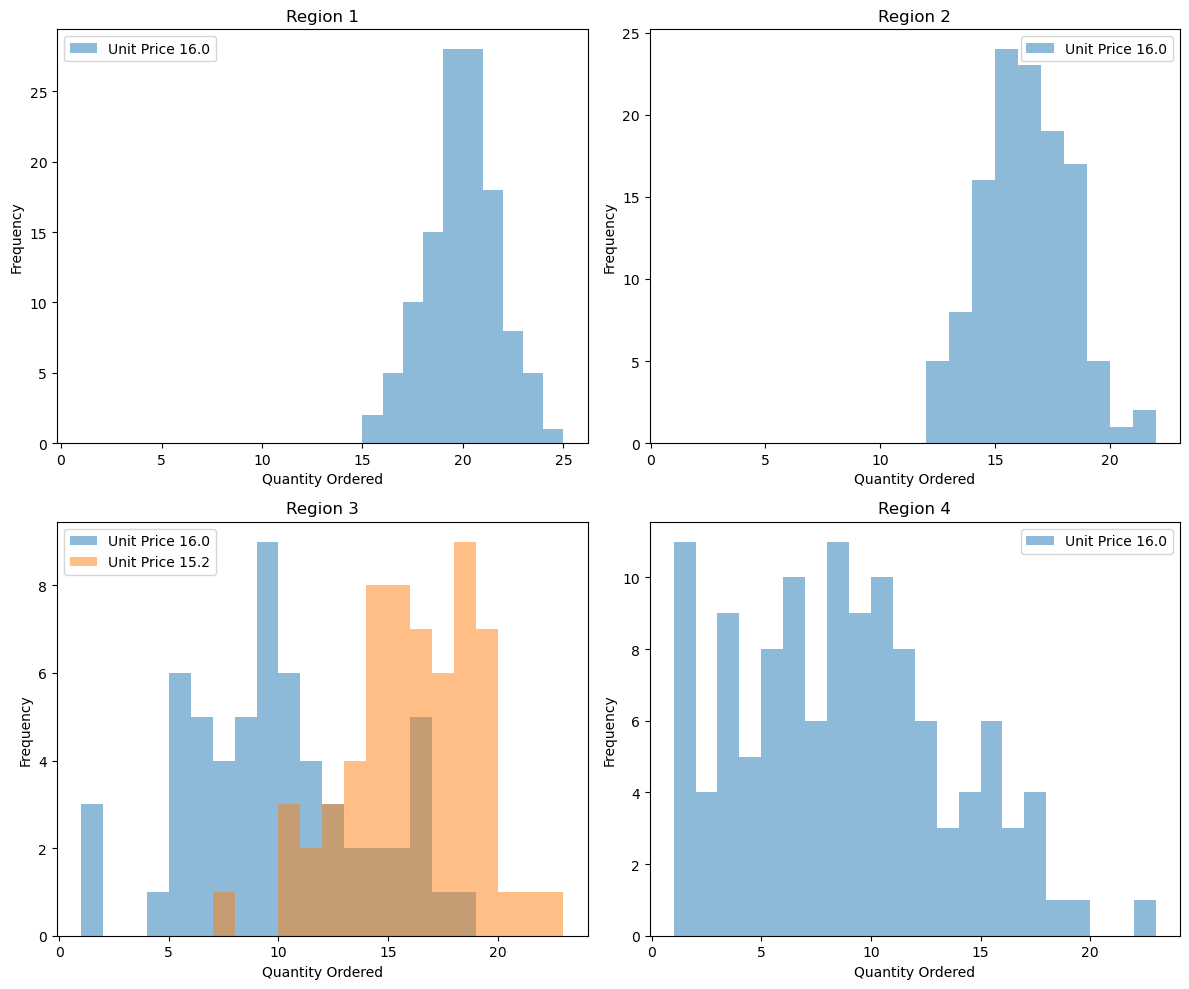

In [ ]:
# Create a figure with 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot histogram for each region and unit price
for i, region in enumerate(df['Region'].unique()):
    region_data = df[df['Region'] == region]
    for unit_price in region_data['Unit Price'].unique():
        unit_price_data = region_data[region_data['Unit Price'] == unit_price]
        axs[i].hist(unit_price_data['Quantity Ordered'], bins=range(1, unit_price_data['Quantity Ordered'].max() + 2), alpha=0.5, label=f'Unit Price {unit_price}')
    
    axs[i].set_xlabel('Quantity Ordered')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Region {region}')
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Parallel Trend Assumption Test

In [12]:
# Testing for parallelism assumption using Prof. Keppo's method from his paper
def parallel_assumption_regression(phase_data, dependent_var):
    # Define the independent variables (Treatment, Phase_2, Phase_3, Treatment_Phase_2, Treatment_Phase_3)
    X = phase_data[['Treatment', 'Phase_2', 'Phase_3','Treatment_Phase_1', 'Treatment_Phase_2', 'Treatment_Phase_3']] ##### 
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression
    print(model.summary())


# for trash in trash_type:
#     print(f"Parallel Assumption Regression for {trash}:")
#     results = parallel_assumption_regression(df_3, trash)
#     all_results.append(results)  # Append results to the list

In [13]:
# # Plot Phase 1 data for each contaminant type

# import seaborn as sns

# import statsmodels.api as sm

# # Function to plot and perform linear regression
# def plot_and_regress(df, contaminant, ax):
#     # Filter data for Phase 1
#     phase_1_data = df[df['FirstTrialPhase'] == 1]
    
#     # Plot the data
#     sns.scatterplot(data=phase_1_data, x='Date', y=contaminant, hue='Area', ax=ax)
    
#     # Perform linear regression for UTOWN
#     utown_data = phase_1_data[phase_1_data['Area'] == 'UTOWN']
#     X_utown = sm.add_constant(utown_data['Date'].map(datetime.toordinal))
#     y_utown = utown_data[contaminant]
#     model_utown = sm.OLS(y_utown, X_utown).fit()
#     ax.plot(utown_data['Date'], model_utown.predict(X_utown), color='orange', label='UTOWN Regression')
    
#     # Perform linear regression for ENGINE
#     engine_data = phase_1_data[phase_1_data['Area'] == 'ENGINE']
#     X_engine = sm.add_constant(engine_data['Date'].map(datetime.toordinal))
#     y_engine = engine_data[contaminant]
#     model_engine = sm.OLS(y_engine, X_engine).fit()
#     ax.plot(engine_data['Date'], model_engine.predict(X_engine), color='blue', label='ENGINE Regression')
    
#     # Set plot title and labels
#     ax.set_title(f'{contaminant} Levels in Phase 1')
#     ax.set_xlabel('Date')
#     ax.set_ylabel(f'{contaminant} Level')
#     ax.legend()
#     ax.tick_params(axis='x', rotation=90)

#     return model_utown, model_engine

# # Create subplots for each contaminant type
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot and regress for each contaminant type
# models = []
# for i, contaminant in enumerate(contaminant_types):
#     model_utown, model_engine = plot_and_regress(df_3, contaminant, axs[i])
#     models.append((model_utown, model_engine))

# plt.tight_layout()
# plt.show()

# # Print the regression summaries
# #for i, contaminant in enumerate(contaminant_types):
# #    print(f"\nUTOWN Regression Summary for {contaminant}:")
# #    print(models[i][0].summary())
# #    print(f"\nENGINE Regression Summary for {contaminant}:")
# #    print(models[i][1].summary())

# add control variable

In [14]:
# df_2['weekend'] = df_2['dow'].apply(lambda x: 1 if x in ['Sunday','Saturday'] else 0 )

In [15]:
# def perform_regression_2(phase_data, dependent_var, trash, case):
#     '''
#     include sunday as control variable
#     '''
#     # Define the independent variables (Treatment, Post, Treatment_Post)
#     X = phase_data[['Treatment', 'Phase_2', 'Phase_3', 'Treatment_Phase_2', 'Treatment_Phase_3','weekend']]
    
#     # Add a constant (intercept) to the independent variables
#     X = sm.add_constant(X)
    
#     # Define the dependent variable
#     y = phase_data[dependent_var]
    
#     # Fit the regression model
#     model = sm.OLS(y, X).fit()

#     results = pd.DataFrame({
#         'Case': case,
#         'Phase&Trash': trash,
#         'Variable': model.params.index,
#         'Coefficient': model.params.values,
#         'P-value': model.pvalues.values
        
#     })
    
#     # Print the summary of the regression
#     print(model.summary())
    
#     return results

In [16]:
# new_results = []
# trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

# for trash in trash_type:
#     print(f"Regression for {trash}:")
#     results = perform_regression_2(df_2, trash, f"{trash}", case = "Case 2")
#     new_results.append(results)  # Append results to the list

# new_results = pd.concat(new_results, ignore_index=True)

In [17]:
# check = pd.merge(final_results, new_results, on=['Case','Phase&Trash','Variable'], suffixes=['_before','_after'])

In [18]:
# # weekend p-value check
# new_results[new_results['Variable']=='weekend']

In [19]:
# # sensitivity check -> almost no change in coefficient_before(no control variable) vs coefficient_after(add control variable)
# diff = check[(check.Variable=='Treatment_Phase_2') |(check.Variable=='Treatment_Phase_3')][['Case','Phase&Trash','Variable','Coefficient_before','Coefficient_after','P-value_before','P-value_after']]
# diff

In [20]:
# diff.to_excel('sensitivity.xlsx')

<!-- # placebo  -->

In [21]:
# fake_date = df_2[df_2['FirstTrialPhase']==1]['Date'].median()
# phase1_end = datetime(2020, 2, 9)
# fake_date

In [22]:
# df_4 = df_2.copy()
# max(df_4.Date)

In [23]:
# def perform_regression(phase_data, dependent_var, trash, case):
#     # Define the independent variables (Treatment, Post, Treatment_Post)
#     X = phase_data[['Treatment', 'Phase_2', 'Treatment_Phase_2']]
    
#     # Add a constant (intercept) to the independent variables
#     X = sm.add_constant(X)
    
#     # Define the dependent variable
#     y = phase_data[dependent_var]
    
#     # Fit the regression model
#     model = sm.OLS(y, X).fit()

#     results = pd.DataFrame({
#         'Case': case,
#         'Phase&Trash': trash,
#         'Variable': model.params.index,
#         'Coefficient': model.params.values,
#         'P-value': model.pvalues.values
#     })
    
#     # Print the summary of the regression
#     print(model.summary())


#     return results

In [24]:
# # preprocessing

# # Adding a new column 'Treatment' that returns 1 when Area is UTOWN and 0 when Area is ENGINE
# df_4['Treatment'] = df_4['Area'].apply(lambda x: 1 if x == 'UTOWN' else 0)

# # Adding two new columns 'Phase_2' and 'Phase_3'
# df_4['Phase_1'] = df_4['Date'].apply(lambda x: 1 if x <= fake_date else 0) ####### ADDED FOR PARALLELISM TEST
# df_4['Phase_2'] = df_4['Date'].apply(lambda x: 1 if (x > fake_date) & (x < phase1_end) else 0)
# # df_4['Phase_3'] = df_4['FirstTrialPhase'].apply(lambda x: 1 if x == 3 else 0)

# # Adding a new column 'Treatment_Post' which is the product of 'Treatment' and 'Phase' columns
# df_4['Treatment_Phase_1'] = df_4['Treatment'] * df_4['Phase_1'] ####### ADDED FOR PARALLELISM TEST
# df_4['Treatment_Phase_2'] = df_4['Treatment'] * df_4['Phase_2']

In [25]:
# all_results = []
# trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

# for trash in trash_type:
#     print(f"Regression for {trash}:")
#     results = perform_regression(df_4, trash, f"{trash}", case = "Case 2")
#     all_results.append(results)  # Append results to the list

# # Concatenate all results into a single DataFrame
# final_results = pd.concat(all_results, ignore_index=True)

In [26]:
# final_results['P-value'] = final_results['P-value'].apply(lambda x: round(x, 5))

In [27]:
# final_results[final_results.Variable=='Treatment_Phase_2']

# Plots: Quantity Ordered vs. Unit Price

TSLS Regression Results:
                          IV2SLS Regression Results                           
Dep. Variable:       Quantity Ordered   R-squared:                      -0.008
Model:                         IV2SLS   Adj. R-squared:                 -0.011
Method:                     Two Stage   F-statistic:                     14.85
                        Least Squares   Prob (F-statistic):           0.000133
Date:                Fri, 08 Nov 2024                                         
Time:                        16:30:40                                         
No. Observations:                 480                                         
Df Residuals:                     478                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.5180     2

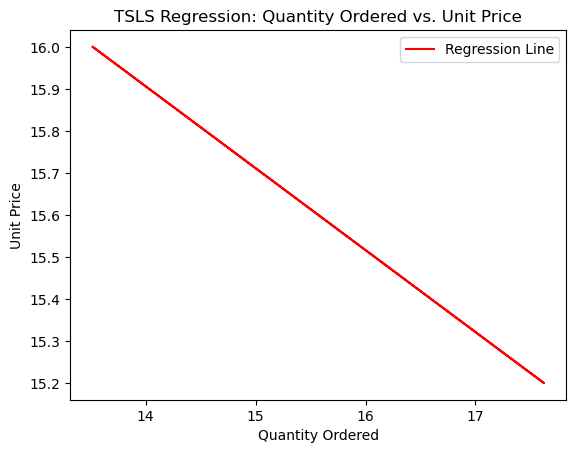

Regression Coefficients:
const         95.518000
Unit Price    -5.124835
dtype: float64


In [28]:
# Define the dependent and independent variables
y = df['Quantity Ordered']
X = df[['Unit Price']] #, 'Discount Applied'
Z = df[['Distance', 'Discount Applied']]  # Instruments

# Add a constant to the independent variable (intercept)
X = sm.add_constant(X)
Z = sm.add_constant(Z)

# Perform TSLS regression
model = IV2SLS(y, X, instrument=Z).fit()

# Print the summary of the regression
print("TSLS Regression Results:")
print(model.summary())
# print("\n")

# Plot X vs Y and add the regression line from the IV2SLS regression
#plt.scatter(y, df['Unit Price'], label='Actual Data')
plt.plot(model.params[0] + model.params[1] * df['Unit Price'], df['Unit Price'], color='red', label='Regression Line')
plt.ylabel('Unit Price')
plt.xlabel('Quantity Ordered')
plt.title('TSLS Regression: Quantity Ordered vs. Unit Price')
plt.legend()
plt.show()
# Plot X vs Y and add the regression line from the IV2SLS regression
# plt.scatter(df['Unit Price'], y, label='Actual Data')
# plt.plot(df['Unit Price'], model.params[0] + model.params[1]x, color='red', label='Regression Line')
# plt.xlabel('Unit Price')
# plt.ylabel('Quantity Ordered')
# plt.title('TSLS Regression: Quantity Ordered vs. Unit Price')
# plt.legend()
# plt.show()

# Plot the TSLS redisuals
#plt.scatter(y, model.predict())
#plt.xlabel('Actual Quantity Ordered')
#plt.ylabel('Predicted Quantity Ordered')
#plt.title('TSLS Regression Results')
#plt.show()

# Print the regression coefficients
print("Regression Coefficients:")
print(model.params)

In [29]:
print(model.params[0])

95.51800038833942


TSLS Regression Results (using OLS):
                            OLS Regression Results                            
Dep. Variable:       Quantity Ordered   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     15.45
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           9.70e-05
Time:                        16:30:41   Log-Likelihood:                -1488.8
No. Observations:                 480   AIC:                             2982.
Df Residuals:                     478   BIC:                             2990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         9

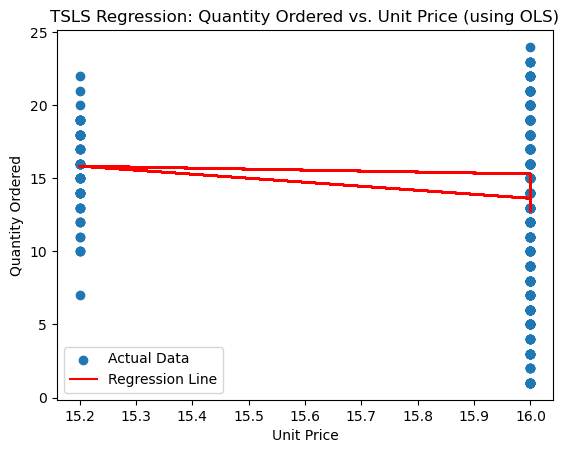

In [30]:
from sklearn.linear_model import LinearRegression

# First stage: Regress the endogenous variable (Unit Price) on the instruments (Distance and Discount Applied)
first_stage_model = LinearRegression()
first_stage_model.fit(Z, X['Unit Price'])
X_hat = first_stage_model.predict(Z)

# Add a constant to the predicted values
X_hat = sm.add_constant(X_hat)

# Second stage: Regress the dependent variable (Quantity Ordered) on the predicted values from the first stage
second_stage_model = sm.OLS(y, X_hat).fit()

# Print the summary of the regression
print("TSLS Regression Results (using OLS):")
print(second_stage_model.summary())

# Plot the regression line
plt.scatter(df['Unit Price'], y, label='Actual Data')
plt.plot(df['Unit Price'], second_stage_model.predict(X_hat), color='red', label='Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Ordered')
plt.title('TSLS Regression: Quantity Ordered vs. Unit Price (using OLS)')
plt.legend()
plt.show()

Perform a two stage least squares with Y (Dependent Variable) as 'Quantity Ordered', X (dependent varialble) as 'Unit Price' and  use 'Discount Applied' as the controll variable. 'Discount Applied' and 'Distance' are the instrumental variables